# 机器学习之高斯混合聚类

#### 【简介】

**高斯混合模型**(Gaussian mixture model，GMM) 就是用**高斯概率密度函数**（二维空间也称为正态分布曲线）精确地**量化事物**，将一个事物**分解**为若干**基于高斯概率密度函数**形成的模型。

高斯混合模型主要用于**聚类**，而且在聚类时需要用到**EM算法**来估计参数。

#### 【目录】

1. [高斯混合聚类的核心思想](#1.-高斯混合聚类的核心思想)
2. [实现高斯混合聚类](#2.-实现高斯混合聚类)
3. [图像分割](#3.-图像分割)

## 1. 高斯混合聚类的核心思想

### 高斯混合分布

**高斯混合聚类**认为数据集中样本的产生过程是由高斯混合分布所给出的。那什么是高斯混合分布呢？

其实很简单，以下面三个图为例：白色的样本点由高斯分布A产生、蓝色的样本点由高斯分布B产生、灰色的样本点由高斯分布C产生。

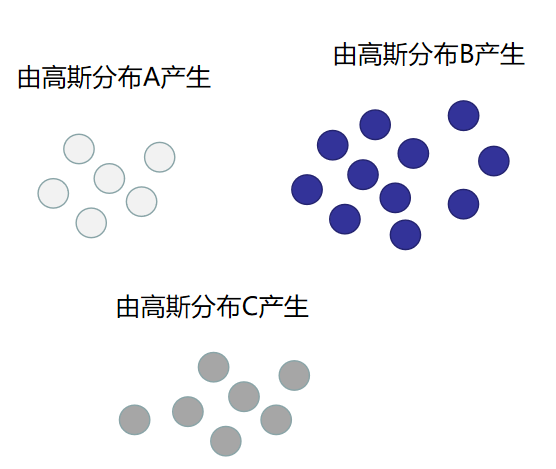

这3个高斯分布可能如下图所示：

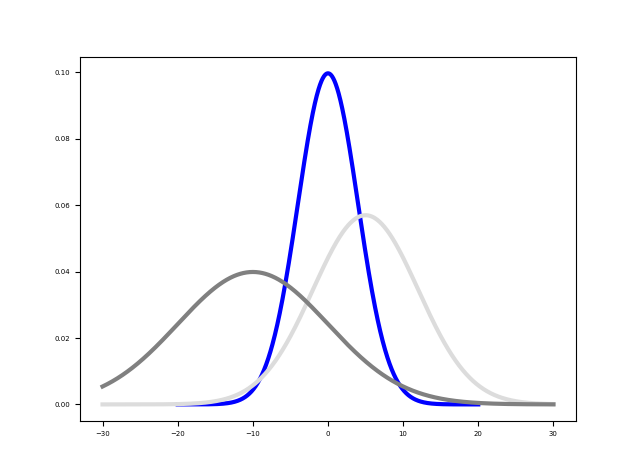

如果想只用一个分布来描述这3个高斯分布的话，我们可能会认为如果我的分布如下图中红色部分所示，就相当于用**一个分布描述了3个高斯分布**。

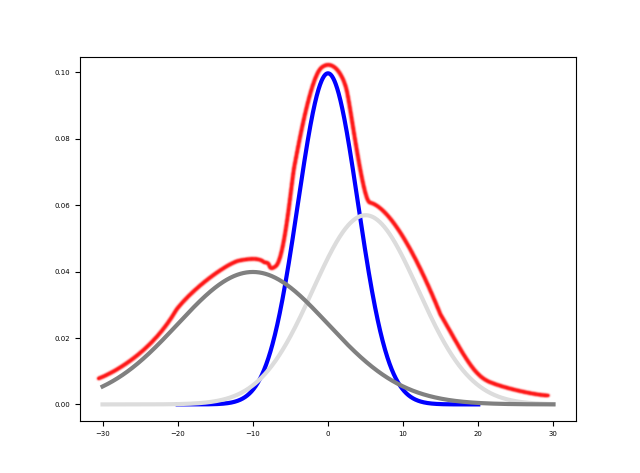

上图中**红色**的分布其实就是**高斯混合分布**。高斯混合分布其实就是多个高斯分布的**带权线性加和**。例如上图中红色的分布等于`0.2*高斯分布A+0.5*高斯分布B+0.3*高斯分布C`。

现在我们对高斯混合分布有了一定的感官上的认识，下面我们给出高斯混合分布的数学定义。

设$p_M(x)$为样本$x$所服从的概率密度函数(高斯混合分布的概率密度函数)，则有：

$$
p_M(x) = \sum_{i=1}^k \alpha_i * p(x|\mu_i, \Sigma_i)
$$

并有：

$$
\sum_{i=1}^k \alpha_i = 1, \alpha_i > 0
$$

其中$\alpha_i$表示第$i$个高斯分布的系数，$p(x|\mu_i, \Sigma_i)$为均值向量为$\mu_i$，协方差矩阵为$\Sigma_i$的高斯分布。

所以在使用高斯混合聚类时，对于样本的产生过程有这样的假设：

- 首先，根据$\alpha_1, \alpha_2, \ldots \alpha_k$定义的先验分布选择高斯分布，其中$\alpha_i$为选择第$i$个高斯分布的概率(这也是所有α的和为1的原因)
- 然后，根据被选择的混合成分的概率密度函数进行采样，从而生成相应的样本

#### 高斯混合聚类的核心思想

现在对样本集$D = \lbrace x_1, x_2, \ldots, x_m \rbrace$ 使用高斯混合聚类划分成$k$个簇。高斯混合聚类会怎样实现呢？其实很简单，如果能分别计算出$x_1$属于$1$号簇的概率，$x_1$属于2号簇的概率，...，$x_k$属于$k$号簇的概率。接着将概率最大的簇作为聚类结果就好了。同样，样本集中的其他样本也如法炮制，就能实现对样本集的聚类。

那么接下来的问题就是怎样计算这个概率？

想要计算这个概率，可以令随机变量$z_j \in \lbrace 1, 2, \ldots, k \rbrace$表示样本$x_i$是从$1$到$k$这$k$个高斯分布中的哪个高斯分布通过采样所得到的（假如$z_1 = 2$表示$x_1$这个样本属于第2个高斯分布，也就是说$x_1$这个样本属于2号簇)。

有了$z_j$这个随机变量后，就可以使用贝叶斯公式将$p_M(z_j=i|x_j)$(即$x_j$属于第$i$个高斯分布的概率)计算出来了：

$$
p_M(z_j=i|x_j) = \frac{P(z_j=i) \cdot p_M(x_j|z_j=i)}{p_M(x_j)} = 
\frac{\alpha_i \cdot p(x_j|\mu_i, \Sigma_i)}{\sum_{l=1}^k \alpha_l \cdot p(x_j|\mu_l, \Sigma_l)}
$$

为了方便描述，我们不妨将$p_M(z_j=i|x_j)$记为$\tau ji$。所以当高斯混合分布已知时，高斯混合聚类将会把样本集$D$划分为$k$个簇，每个样本$x_j$的簇标记$\lambda_j$以如下方式确定：

$$
\lambda_j = argmax_{i \in \lbrace 1,2,\ldots,k \rbrace}\tau ji
$$

## 2. 实现高斯混合聚类

### 任务描述

用python实现高斯混合聚类算法。

### 相关知识

为了完成本任务，需要掌握高斯混合聚类算法的流程

#### 高斯混合聚类算法的流程

在上一节已经介绍了高斯混合聚类算法的核心思想，并知道$\tau ji$与$\alpha_i,\mu_i,\Sigma_i$有关。所以高斯混合聚类算法的训练过程就是找到合适的$\alpha_i,\mu_i,\Sigma_i$的过程。在高斯混合聚类算法中通常使用**EM算法**来估计这些参数。

**EM算法**的**E步**比较简单，就是根据当前的$\alpha_i,\mu_i,\Sigma_i$计算出$\tau ji$。麻烦的是**M步**， M步中需要知道怎样更新$\alpha_i,\mu_i,\Sigma_i$。所以我们不妨简单地推导一下。

假设有一个包含$m$条样本的数据集$D$，那么似然函数$L(D)$如下：

$$
L(D)=\prod_{j=1}^m p_M(x_j)
$$

则其对数似然函数$LL(D)$如下：

$$
LL(D)=\sum_{i=1}^m ln(\sum_{i=1}^k \alpha_i * p(x|\mu_i, \Sigma_i))
$$

为了使得$LL(D)$最大化，则需要分别计算偏导，并使得偏导为$0$。因此计算结果如下：

$$
\mu_i = \frac{\sum_{j=1}^m \tau ji x_j}{\sum_{j=1}^m \tau ji}
$$

$$
\Sigma_i = \frac{\sum_{j=1}^m \tau ji(x_j - \mu_i)(x_j - \mu_i)^T}{\sum_{j=1}^m \tau ji}
$$

$$
\alpha_i = \frac{1}{m} \sum_{i=1}^m \tau ji
$$

所以**EM算法**的**M步**就是根据上面的式子更新参数。

最后总结一下高斯混合聚类算法的流程。

1. 初始化参数
2. EM算法更新参数
3. 根据高斯混合分布确定簇的划分

### 实操练习

#### 编程要求
根据提示，补充`Begin-End`段中的代码，完成`fit`函数和`predict`函数。`fit`函数需要完成的功能是根据高斯混合聚类算法的训练流程将参数分别保存至`self.alpha`，`self.mu`， `self.sigma`中。`predict`函数需要完成的功能是对数据集进行聚类，并将聚类结果返回。

【提示】计算$p(x|\mu_i,\Sigma_i)$可以使用如下代码:

#### 测试说明

输出聚类结果的FM指数，应高于0.75

In [38]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM(object):
    def __init__(self, n_components, max_iter=100):
        '''
        构造函数
        :param n_components: 想要划分成几个簇，类型为int
        :param max_iter: EM的最大迭代次数
        '''
        self.n_components = n_components
        self.max_iter = max_iter
    def fit(self, train_data):
        '''
        训练，将模型参数分别保存至self.alpha，self.mu，self.sigma中
        :param train_data: 训练数据集，类型为ndarray
        :return: 无返回
        '''
        row, col = train_data.shape
        # 初始化每个高斯分布的响应系数
        self.alpha = np.array([1.0 / self.n_components] * self.n_components)
        # 初始化每个高斯分布的均值向量
        self.mu = np.random.rand(self.n_components, col)
        # 初始化每个高斯分布的协方差矩阵
        self.sigma = np.array([np.eye(col)] * self.n_components)
        #********* Begin *******#
        for j in range(self.max_iter):
            # e-step
            # 响应度矩阵，行对应样本，列对应响应度
            gamma = np.zeros((row, self.n_components))
            prob = np.zeros((row, self.n_components))
            # 计算各高斯分布中所有样本出现的概率，行对应样本，列对应高斯分布
            for k in range(self.n_components):
                prob[:, k] = multivariate_normal(mean=self.mu[k], cov=self.sigma[k]).pdf(train_data)
            for k in range(self.n_components):
                gamma[:, k] = self.alpha[k] * prob[:, k]
            for i in range(row):
                gamma[i, :] /= np.sum(gamma[i, :])
            # m-step
            for k in range(self.n_components):
                # 第k个模型对所有样本的响应度之和
                Nk = np.sum(gamma[:, k])
                # 更新 mu
                # 对每个特征求均值
                self.mu[k, :] = np.sum(train_data * gamma[:, k].reshape(-1, 1), axis=0) / Nk
                # 更新 cov
                cov_k = np.matmul((train_data - self.mu[k]).T, (train_data - self.mu[k]) * gamma[:, k].reshape(-1, 1)) / Nk
                self.sigma[k, :, :] = cov_k
                # 更新 alpha
                self.alpha[k] = Nk / row
        #********* End *********#
        
    def predict(self, test_data):
        '''
        预测，根据训练好的模型参数将test_data进行划分。
        注意：划分的标签的取值范围为[0,self.n_components-1]，即若self.n_components为3，则划分的标签的可能取值为0,1,2。
        :param test_data: 测试集数据，类型为ndarray
        :return: 划分结果，类型为你ndarray
        '''
        #********* Begin *********#
        gamma = np.zeros((len(test_data), self.n_components))
        prob = np.zeros((len(test_data), self.n_components))
        for k in range(self.n_components):
            prob[:, k] = multivariate_normal(mean=self.mu[k], cov=self.sigma[k]).pdf(test_data)
        for k in range(self.n_components):
            gamma[:, k] = self.alpha[k] * prob[:, k]
        for i in range(len(test_data)):
            gamma[i, :] /= np.sum(gamma[i, :])
        return gamma.argmax(axis=1).flatten()
        #********* End *********#

In [39]:
# 测试代码
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.datasets import load_wine

# 加载红酒数据集
wine = load_wine()
# 标准化
scaler = StandardScaler()
X = scaler.fit_transform(wine.data)
y = wine.target
# 创建聚类模型
gmm = GMM(n_components=3)
gmm.fit(X)
y_pred = gmm.predict(X)
# 计算FM指数
fm = fowlkes_mallows_score(y, y_pred)
print('FM指数：{:.2f}'.format(fm))

FM指数：0.77


In [40]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [41]:
y_pred

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

检查一下，FM指数是否跟标签ID有关。

In [42]:
y[y == 0] = -1
y[y == 1] = -2
y[y == 2] = -3
y

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -3, -3, -3, -3, -3, -3,
       -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3,
       -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3,
       -3, -3, -3, -3, -3, -3, -3, -3])

In [43]:
y_pred[y_pred == 0] = -3
y_pred[y_pred == 1] = -2
y_pred[y_pred == 2] = -1
y_pred

array([-3, -3, -3, -3, -1, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3,
       -3, -3, -1, -3, -1, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3,
       -3, -3, -3, -3, -3, -1, -3, -1, -3, -1, -3, -1, -1, -3, -3, -3, -3,
       -3, -3, -3, -3, -3, -3, -3, -3, -2, -3, -2, -3, -2, -2, -3, -3, -3,
       -3, -2, -2, -2, -2, -2, -2, -2, -3, -2, -2, -2, -2, -3, -2, -1, -2,
       -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -3, -2, -2, -3,
       -2, -2, -3, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -3, -2,
       -2, -2, -1, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, -1, -1, -1, -1,
       -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1])

In [44]:
# 计算吻合度
fm = fowlkes_mallows_score(y, y_pred)
print('FM指数：{:.2f}'.format(fm))

FM指数：0.77


看来，FM指数跟标签ID是否一致无关。

## 3. 图像分割

### 任务描述

编写Python程序对图像进行分割。

原图如下：

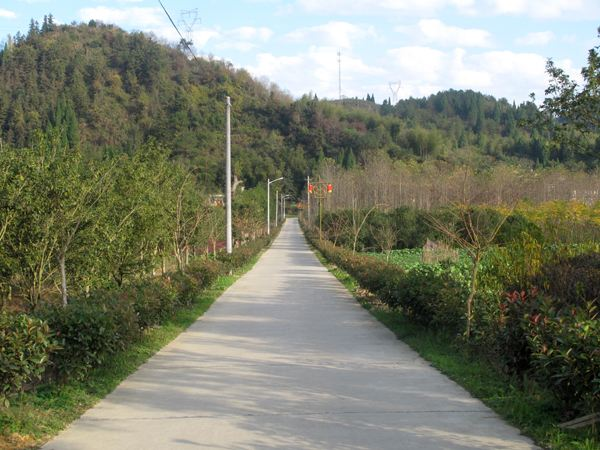

分割图像如下：

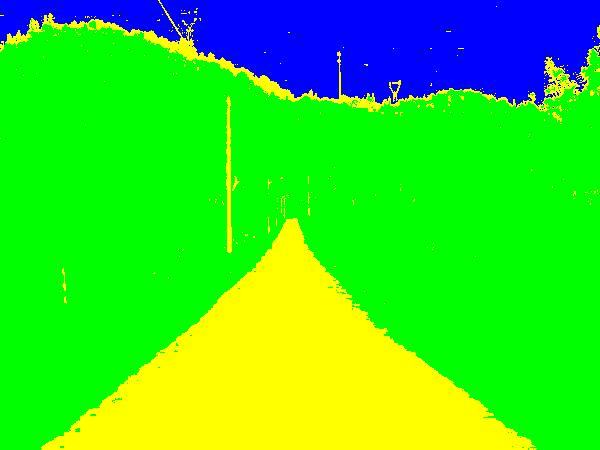

### 相关知识

为了完成本任务，需要掌握：

- 聚类与图像分割
- 图像的基础操作
- 如何使用GaussianMixture

#### 聚类与图像分割

图像分割非常好理解，如上面的图所示，就是将图像划分成若干个不同的部分(分割结果可以看出将原图划分成了 3 个部分：道路、树林、天空)。

那么图像分割怎样和聚类扯上关系呢？很简单，我们知道一副彩色图像是由多个像素点组成的。若把每个像素点看成是一个样本的话，我们就可以通过聚类的方式给每个像素点打上簇标记（比如 0,1,2）。然后再根据簇标记将像素点设置成想要的颜色（比如簇标记为 0 的设置成黄色，簇标记为 1 的设置成绿色，簇标记为 2 的设置成蓝色），然后可视化出来就能得到图像分割的效果。

那么怎样将一副图像转换成我们通常想要的类似表格的数据呢？也很简单，一副彩色图像是由多个像素点组成的，而一个像素点一般是由 R，G，B 三个通道组成的。那么我们可以把每一个像素点看成是数据集中的一个样本，每个样本包含 3 个特征（RGB三个通道的值）。所以如果一副彩色图的高是200，宽是300。则该图可以看成是一个 60000行，3列的数据集。有了我们喜闻乐见的表格数据后，就可以将数据传递给聚类算法进行聚类了。

#### 图像的基础操作

我们可以使用 PIL 来对图像进行操作。如果你想读取一幅图或者保存一副图，代码如下：

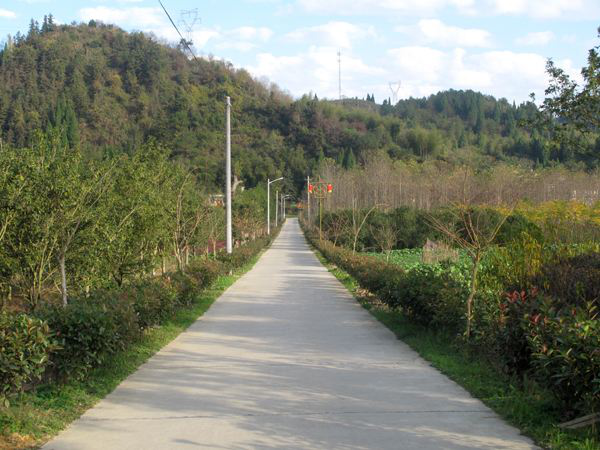

In [12]:
from PIL import Image
# 读取road.jpg到im变量中
im = Image.open('data/road.jpg')
# 显示图片
im

值得注意的是，当使用`Image.open`函数读取到图像后，我们不能直接将图像传给`sklearn`的聚类算法接口。因为此时的`im`不是`ndarray`或者`list`，而且 im 的形状不是喜闻乐见的表格的形状。所以需要进行转换，代码如下：

In [13]:
import numpy as np
# 将im转换成ndarray
img = np.array(im)
# 将img变形为[-1, 3]的shape，并保存至img_reshape
img_reshaped = img.reshape(-1, 3)
img.shape, img_reshaped.shape

((450, 600, 3), (270000, 3))

当聚类算法给出结果后，我们需要根据聚类结果给图像上色，代码如下：

In [14]:
# pred为聚类算法的预测结果，将簇为0的点设置成红色，簇为1的点设置成蓝色
y_pred = np.zeros(img_reshaped.shape[0])
y_pred[:len(y_pred)//2] = 1
img_reshaped[y_pred == 0, :] = [255, 0, 0]
img_reshaped[y_pred == 1, :] = [0, 0, 255]

由于img_reshaped 为 ndarray，我们需要将其转成 Image 类型才能使用 save 函数实现保存图片的功能。转换代码如下：

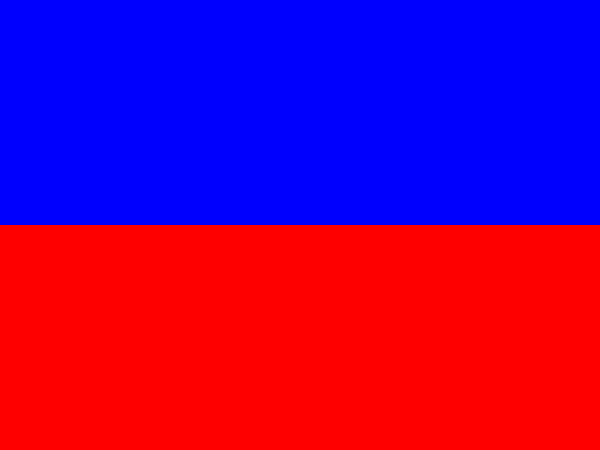

In [15]:
im = Image.fromarray(img_reshaped.reshape(450, 600, 3).astype('uint8'))
im

#### 如何使用 GaussianMixture

`GaussianMixture`是`sklearn`提供的高斯混合聚类的一个类，该类的构造函数中可以根据实际需要设置很多参数。但常用的参数是`n_components`和`max_iter`。其中：

- `n_components`：想要聚成几个簇，类型为`int`
- `max_iter`：迭代次数，类型为`int`

使用`GaussianMixture`进行聚类很简单，`fit`-`predict`大法就完事了。代码如下：

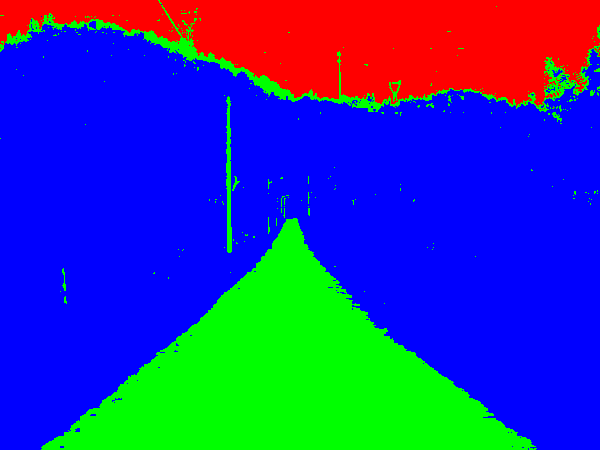

In [18]:
from sklearn.mixture import GaussianMixture
# 获取并转换图像
im = Image.open('data/road.jpg')
img2 = np.array(im)
img_ = img2.reshape(-1, 3)
# 实例化一个将数据聚成3个簇的高斯混合聚类器
gmm = GaussianMixture(3)
# 将数据传给fit函数，fit函数会计算出各个高斯分布的参数和响应系数
gmm.fit(img_)
# 对数据进行聚类，簇标记为0或1(因为gmm对象想要聚成2个簇)
y_pred_ = gmm.predict(img_)
# 图省事可以这样，相当于调用了fit之后调用predict
# pred = gmm.fit_predict(img_reshape)
img_[y_pred_ == 0, :] = [255, 0, 0]
img_[y_pred_ == 1, :] = [0, 0, 255]
img_[y_pred_ == 2, :] = [0, 255, 0]
im = Image.fromarray(img_.reshape(450, 600, 3).astype('uint8'))
im

### 实操练习

补充`begin-end`之间的代码，实现以下功能：

- 读取`.data/cat.jpg`
- 将读取到的图像分割成3个部分。其中簇标记为0的部分用红表示；簇标记为1的部分用绿色表示；簇标记为2的部分用蓝色表示。

将分割后的图像保存至`./data/gmm_result.jpg`

### 测试说明

输出分割后的图像

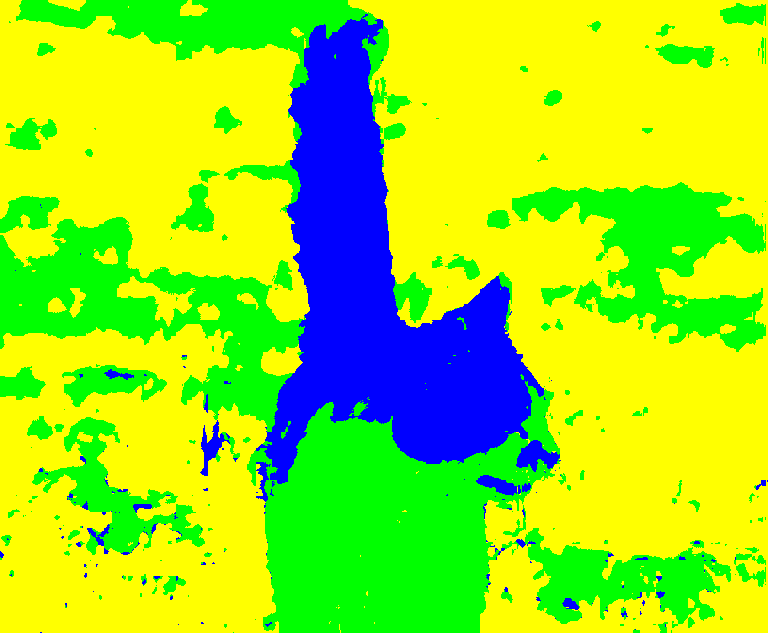

In [21]:
from PIL import Image
import numpy as np
from sklearn.mixture import GaussianMixture
#******** Begin *********#
im = Image.open('data/cat.jpeg')
img = np.array(im)
h, w, c = img.shape
img = img.reshape(-1, 3)
gmm = GaussianMixture(3)
gmm.fit(img)
pred = gmm.predict(img)
pred = pred.reshape(h, w)
result = np.zeros((h, w, c))
result[pred == 0, :] = [255, 255, 0]
result[pred == 1, :] = [0, 0, 255]
result[pred == 2, :] = [0, 255, 0]
result = Image.fromarray(result.astype('uint8'))
result.save('data/gmm_result.jpg')
result
#********* End **********#